In [ ]:
import pandas as pd
from google.colab import files
import io
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Functions for loading data

def mount_drive():
  drive.mount("/content/drive")

def load_subreddit_data(filename="reddit_train.csv"):
  uploaded = files.upload()
  return pd.read_csv(io.BytesIO(uploaded[filename]), encoding='latin1')

def load_subreddit_data2(filename="reddit_test.csv"):
  uploaded = files.upload()
  return pd.read_csv(io.BytesIO(uploaded[filename]), encoding='latin1')

In [ ]:
train_data = load_subreddit_data()
test_data = load_subreddit_data2()

Saving reddit_train.csv to reddit_train (1).csv


Saving reddit_test.csv to reddit_test (1).csv


KeyError: ignored

In [ ]:
full_data = train_data.append(test_data)

In [ ]:
full_data

,Unnamed: 0,X,BODY,REMOVED
0,8756,8877,Always be wary of news articles that cite unpu...,0
1,7330,7432,The problem I have with this is that the artic...,0
2,15711,15944,"This is indicative of a typical power law, and...",0
3,1604,1625,This doesn't make sense. Chess obviously trans...,0
4,13327,13520,1. I dispute that gene engineering is burdenso...,0
...,...,...,...,...
7106,14734,14949,&gt;The findings were based on two surveys of ...,0
7107,19681,20317,Why not Open Access? Perhaps this research was...,1
7108,19688,20324,So what you're saying is that getting a tattoo...,1
7109,26673,28153,I can attest to this. The past week and a half...,1


In [ ]:
nfull_data = pd.concat([full_data,testrule1],axis = 0)

In [ ]:
nfull_data

,Unnamed: 0,X,BODY,REMOVED
0,8756.0,8877.0,Always be wary of news articles that cite unpu...,0.0
1,7330.0,7432.0,The problem I have with this is that the artic...,0.0
2,15711.0,15944.0,"This is indicative of a typical power law, and...",0.0
3,1604.0,1625.0,This doesn't make sense. Chess obviously trans...,0.0
4,13327.0,13520.0,1. I dispute that gene engineering is burdenso...,0.0
...,...,...,...,...
7110,9326.0,9455.0,How much does it cost to produce a gram though?,0.0
0,978220.0,55426.0,Let's not forget that Global Warming is just a...,1.0
1,180705.0,141002.0,I thought it was caused by a chemical imbalanc...,1.0
2,389562.0,198995.0,It's supoosed to work that way. Scientifically...,1.0


In [ ]:
full_data = nfull_data

In [ ]:


y_train = full_data['REMOVED']

full_data.drop(labels='REMOVED', axis=1, inplace=True)

full_data['BODY'] = full_data['BODY'].fillna("").map(word_tokenize)
full_data['KEYWORDS'] = full_data['BODY'].map(FreqDist)

stop_words = stopwords.words("english")


def filterSentence(sentence):
    filteredSentence = []
    for w in sentence:
        if w not in stop_words:
            filteredSentence.append(w)
    return filteredSentence


full_data['KEYWORDS'] = full_data['BODY'].map(filterSentence)
full_data.drop('BODY', axis=1, inplace=True)

X = []

for elem in full_data['KEYWORDS']:
    X.append(' '.join(elem))

X = [str(item) for item in X]

vectorizer = TfidfVectorizer(encoding='latin1', ngram_range=(1, 3), min_df=0.001, max_df=0.25)

X_train = vectorizer.fit_transform(X)

In [ ]:
testset = X_train[28447:,]

In [ ]:
X_train = X_train[0:28447,]

In [ ]:
y_train[0:28447,]

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
7106    0.0
7107    1.0
7108    1.0
7109    1.0
7110    0.0
Name: REMOVED, Length: 28447, dtype: float64

In [ ]:
testy = y_train[28447:,]

In [ ]:
testy = np.ones((32))
testy

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
testset

<32x4783 sparse matrix of type '<class 'numpy.float64'>'
	with 587 stored elements in Compressed Sparse Row format>

In [ ]:
y_train= y_train[0:28447,]

In [ ]:
# Normalization and Splitting

scaler = MaxAbsScaler()
X_train = scaler.fit_transform(X_train)

seed = 14
test_size = 0.30

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=test_size, random_state=seed)

In [ ]:
# Grid-Search Cross Validation

param_test1 = {'n_estimators': range(20, 81, 10)}
gsearch1 = GridSearchCV(
    estimator=GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500, min_samples_leaf=50, max_depth=8,
                                         max_features='sqrt', subsample=0.8, random_state=10),
    param_grid=param_test1, scoring='roc_auc', n_jobs=4, cv=5)
gsearch1.fit(X_train, y_train)
print(gsearch1.best_params_, gsearch1.best_score_) # Returns n_estimators=80 as optimal value in our tests

param_test2 = {'max_depth': range(5, 16, 2), 'min_samples_split': range(200, 1001, 200)}
gsearch2 = GridSearchCV(
    estimator=GradientBoostingClassifier(learning_rate=0.1, n_estimators=80, min_samples_leaf=50, max_features='sqrt',
                                         subsample=0.8, random_state=10),
    param_grid=param_test2, scoring='roc_auc', n_jobs=4, cv=5)
gsearch2.fit(X_train, y_train)
print(gsearch2.best_params_, gsearch2.best_score_) # Returns max_depth=15 and min_samples_split=600 as optimal values in our tests

param_test3 = {'max_features': range(7, 20, 2), 'min_samples_leaf': range(30, 71, 10)}
gsearch3 = GridSearchCV(
    estimator=GradientBoostingClassifier(learning_rate=0.1, n_estimators=80, min_samples_split=600, max_depth=15,
                                         subsample=0.8, random_state=10),
    param_grid=param_test3, scoring='roc_auc', n_jobs=4, cv=5)
gsearch3.fit(X_train, y_train)
print(gsearch3.best_params_, gsearch3.best_score_) # Returns max_features=19 and min_samples_leaf=30 as optimal values in our tests

param_test4 = {'subsample': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9]}
gsearch4 = GridSearchCV(
    estimator=GradientBoostingClassifier(learning_rate=0.1, n_estimators=80, max_features=19, min_samples_leaf=30,
                                         max_depth=15, min_samples_split=600, random_state=10),
    param_grid=param_test4, scoring='roc_auc', n_jobs=4, cv=5)
gsearch4.fit(X_train, y_train)
print(gsearch4.best_params_, gsearch4.best_score_) # Returns subsample=0.9 as optimal value in our tests

param_test5 = {'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]}
gsearch5 = GridSearchCV(
    estimator=GradientBoostingClassifier(n_estimators=80, max_features=19, min_samples_leaf=30, max_depth=15,
                                         min_samples_split=600, subsample=0.9, random_state=10),
    param_grid=param_test5, scoring='roc_auc', n_jobs=4, cv=5)
gsearch5.fit(X_train, y_train)
print(gsearch5.best_params_, gsearch5.best_score_) # Returns learning_rate=0.15 as optimal value in our tests

KeyboardInterrupt: ignored

In [ ]:
# Fitting and Evaluation Metrics

gb_clf2 = GradientBoostingClassifier(learning_rate=0.3, n_estimators=80, max_features=17, min_samples_leaf=30,
                                     max_depth=15, min_samples_split=200, subsample=0.8, random_state=10)
gb_clf2.fit(X_train, y_train)
predictions = gb_clf2.predict(X_val)

print("Confusion Matrix:")
print(confusion_matrix(y_val, predictions))

print("Classification Report")
print(classification_report(y_val, predictions))

Confusion Matrix:
[[5166  632]
 [1707 1030]]
Classification Report
              precision    recall  f1-score   support

         0.0       0.75      0.89      0.82      5798
         1.0       0.62      0.38      0.47      2737

    accuracy                           0.73      8535
   macro avg       0.69      0.63      0.64      8535
weighted avg       0.71      0.73      0.70      8535



In [ ]:
# Fitting and Evaluation Metrics

gb_clf2 = GradientBoostingClassifier(learning_rate=0.3, n_estimators=80, max_features=17, min_samples_leaf=30,
                                     max_depth=15, min_samples_split=200, subsample=0.8, random_state=10)
gb_clf2.fit(X_train, y_train)
predictions = gb_clf2.predict(testset)

print("Confusion Matrix:")
print(confusion_matrix(testy.dropna(), predictions))

print("Classification Report")
print(classification_report(testy.dropna(), predictions))

In [ ]:
X_train

<19912x4781 sparse matrix of type '<class 'numpy.float64'>'
	with 464116 stored elements in Compressed Sparse Row format>

In [ ]:
testset

<32x4781 sparse matrix of type '<class 'numpy.float64'>'
	with 48 stored elements in Compressed Sparse Row format>

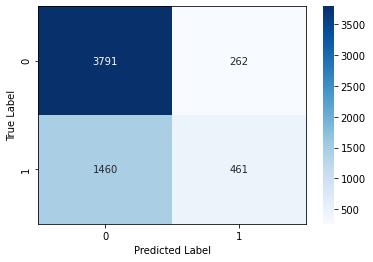

In [ ]:
# Heatmap of Confusion Matrix

cf_matrix = confusion_matrix(y_val, predictions)
heatmap = sns.heatmap(cf_matrix, annot=True, fmt='0.5g', cmap='Blues')
for _, spine in heatmap.spines.items():
    spine.set_visible(True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
def load_subreddit_data3(filename="testrule4.csv"):
  uploaded = files.upload()
  return pd.read_csv(io.BytesIO(uploaded[filename]), encoding='latin1')

In [ ]:
testrule1 = load_subreddit_data3()

Saving testrule4.csv to testrule4.csv


In [ ]:
testrule1 = testrule1.dropna()

In [ ]:
test2_data.head()

,ï»¿body,rule,label
0,Imagine if this find was the bug that eradicat...,1.0,1.0
1,"Currently, there's some dude with a skeleton j...",1.0,1.0
2,I don't need any research to know you don't tr...,1.0,1.0
3,Isnt this the start of a Will Smith movie?,1.0,1.0
4,I get more loads out under the influence of THC,3.0,1.0


In [ ]:
list(test2_data.columns)

['ï»¿body', 'rule', 'label']

In [ ]:
test2_data.dropna()

,ï»¿body,rule,label
0,Imagine if this find was the bug that eradicat...,1.0,1.0
1,"Currently, there's some dude with a skeleton j...",1.0,1.0
2,I don't need any research to know you don't tr...,1.0,1.0
3,Isnt this the start of a Will Smith movie?,1.0,1.0
4,I get more loads out under the influence of THC,3.0,1.0
...,...,...,...
95,"What if that"" happiness "" is actually a mask f...",4.0,1.0
96,Just like lsd was at some point used to treat ...,1.0,1.0
97,"Meh, fuck the doers. They have nothing on us.",1.0,1.0
98,So democracy is not going to work out much lon...,1.0,1.0


In [ ]:
test2_data1 = test2_data.loc[test2_data["rule"] == 1.0,:].copy()
test2_data1.head()

,ï»¿body,rule,label
0,Imagine if this find was the bug that eradicat...,1.0,1.0
1,"Currently, there's some dude with a skeleton j...",1.0,1.0
2,I don't need any research to know you don't tr...,1.0,1.0
3,Isnt this the start of a Will Smith movie?,1.0,1.0
6,Again? How many times do you have to bang your...,1.0,1.0


In [ ]:
y2_test = test2_data1['label'].copy()

In [ ]:
test2_data1.drop(labels='label', axis=1, inplace=True)


In [ ]:
test2_data1.drop(labels='rule', axis=1, inplace=True)

In [ ]:
test2_data1['ï»¿body'] = test2_data1['ï»¿body'].fillna("").map(word_tokenize)
test2_data1['KEYWORDS'] = test2_data1['ï»¿body'].map(FreqDist)

In [ ]:
stop_words = stopwords.words("english")


def filterSentence(sentence):
    filteredSentence = []
    for w in sentence:
        if w not in stop_words:
            filteredSentence.append(w)
    return filteredSentence


test2_data1['KEYWORDS'] = test2_data1['ï»¿body'].map(filterSentence)
test2_data1.drop('ï»¿body', axis=1, inplace=True)

In [ ]:

X2 = []

for elem in test2_data1['KEYWORDS']:
    X2.append(' '.join(elem))

X2 = [str(item) for item in X2]

vectorizer = TfidfVectorizer(encoding='latin1', ngram_range=(1, 3), min_df=0.001, max_df=0.25)

X2_train = vectorizer.fit_transform(X2)

In [ ]:
X2_train

<42x1054 sparse matrix of type '<class 'numpy.float64'>'
	with 1116 stored elements in Compressed Sparse Row format>

In [ ]:
# Normalization and Splitting

scaler = MaxAbsScaler()
X2_train = scaler.fit_transform(X2_train)



In [ ]:
X2_train

<42x1054 sparse matrix of type '<class 'numpy.float64'>'
	with 1116 stored elements in Compressed Sparse Row format>

In [ ]:
# trying to pad with 0's lol but idt this is the way
z = coo_matrix(np.zeros((42,3727)))
z

<42x3727 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in COOrdinate format>

In [ ]:
from scipy.sparse import csr_matrix,coo_matrix,hstack

In [ ]:
import scipy.sparse

In [ ]:
X3_train = hstack((X2_train,z))
X3_train

<42x4781 sparse matrix of type '<class 'numpy.float64'>'
	with 1116 stored elements in COOrdinate format>

In [ ]:
gb_clf22 = GradientBoostingClassifier(learning_rate=0.15, n_estimators=80, max_features=19, min_samples_leaf=30,
                                     max_depth=15, min_samples_split=600, subsample=0.9, random_state=10)
gb_clf22.fit(X_train, y_train)
predictions = gb_clf22.predict(X2_train)

ValueError: ignored

In [ ]:
print("Confusion Matrix:")
print(confusion_matrix(y2_test, predictions))

print("Classification Report")
print(classification_report(y2_test, predictions))